# Introduction

A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

# 1. Understand data and preprocessing

In this problem, we try to predict a number of review of AirBNB listing per month(`reviews_per_month`) so we can predict whether listing will be popular once create it. There are totally 16 variables with a combination of numeric, categorical, and text features such as
- `id` : Numerical data but not related to our problem and should be drop.                            
- `name` : Review from users, should be transformed with Bag-of-word.                       
- `host_id` : Unique id of hosts.                         
- `host_name` : Name of hosts, not related and got ethic problem, so should be drop.                      
- `neighbourhood_group` : Categorical data of neighbourhood groups.          
- `neighbourhood` : Categorical data of neighbourhoods.                  
- `latitude` : Latitude of each properties.                      
- `longitude` : Longitude of each properties.                     
- `room_type` : Type of rooms (Categorical).                     
- `price` : Price of each listing.                           
- `minimum_nights` : A minimum number of staying night.               
- `number_of_reviews` : A number of reviews of each properties.               
- `last_review` : Last time when it got reviewed.                     
- `reviews_per_month` : A number of reviews per months that we want to predict.             
- `calculated_host_listings_count` : Number of listing by hosts. 
- `availability_365` : Availability of listing per year.               

After reading the data as Pandas dataframe, I started checking into the data by airbnb.head() and airbnb.info(), I could see that we have a good size of data with 48,895 observations in total, and I also found that there are some missing-value features in this dataset that need to be handle as well.

I therefore started thinking about this problem. I thought that there are some features that we should not be useful for prediction such as `id` and `last_review`. Also there is one feature that should not be related and we should not be used in term of ethic such as `host_name` as well. Therefore I decided to drop these 3 features.

I then thought about handling the missing-value data, there are several ways to deal with it, but I finally decided to drop the missing-value data since I am not sure whether what data should be used to fill it. You may argue that we can fill it with zero, but in this case, since we can not talk to the domain expert or the person who collected the data, so I think it is better to drop these missing values. In addition, even we drop these missing values, we still have a good size of data of 38,837 observations.

Furthermore, if we can discuss this to the domain expert, we may know more how to treat these missing values. Other methods that we can consider may be filling with,
- fill with zero
- fill with mean value
- Knn imputer
we can try these methods as well if we have time.

I also changes the column name of `availability_365` to be `availability` to be more meaningful and easy to understand.

Lastly, after checking the data, I personally think that it is weird that we have feature `number_of_review` since , in general, the `number_of_review` will be pretty much the same as `review_per_month` that we want to predict. If the `number_of_review` is high, the `review_per_month` will be high as well. We can also see this from correlation coefficient of these two, 0.71 (Spearman).

In [1]:
# import libraries
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import warnings
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import altair as alt
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Include an image for each plot since Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import RandomizedSearchCV

In [2]:
#1.1 Import data as dataframe and preliminary check the data
airbnb = pd.read_csv('data/AB_NYC_2019.csv')
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
#1.2 Checking data with .info() to see type and missing value
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
#1.3 Decide to drop some features since they are unrelated to prediction and ethic problem
airbnb = airbnb.drop(columns = ['id','last_review','host_name'])
airbnb.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [5]:
#1.4 Check NA/missing-value data
airbnb.isna().sum()

name                                 16
host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
#1.5 Decide to drop NA/missing value, and we still have a good size of data
airbnb = airbnb.dropna()
airbnb.isna().sum()

name                              0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [7]:
#1.6 Review the updated data
airbnb.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129


In [8]:
#1.7 Change column names to be meaningful names
airbnb.rename(columns = {'availability_365':'availability'}, inplace = True)
airbnb.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129


# 2. Data splitting

- I started with spliting train and test data set with 70%-30% ratio but it took very long time to train the model and finally my laptop was hank.

- I then decided to split train and test data as 50%-50% ratio, but it still took a very long time running some model such as RidgeCV, I finally decided to use 30%-70% ratio, even with 30% training data, we still have a good size of data to train the model, 11651 observations.

- Please be noted that we can increase the train data size if we have more powerful resources or want the better result.

In [9]:
#2.1 Splitting data with 50-50 ratio
train_df, test_df = train_test_split(airbnb, test_size=0.7, random_state=123)
train_df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability
21772,Luxurious Manhattan 1 Bedroom,3191545,Manhattan,Hell's Kitchen,40.76589,-73.98434,Entire home/apt,199,30,6,0.23,23,365
17591,Sunny room in modern building located in Bedstuy,252059,Brooklyn,Bedford-Stuyvesant,40.69181,-73.94312,Private room,60,5,3,0.08,1,0
15594,"Penthouse 2BR w skylight,terrace, and a roof d...",68094795,Manhattan,Upper East Side,40.76532,-73.96150,Entire home/apt,399,4,55,1.47,2,237
41598,Convenient 2 bedroom apt near Times Sq. 1C,190921808,Manhattan,Hell's Kitchen,40.75393,-73.99667,Entire home/apt,500,3,2,0.81,47,352
29321,Dina airbnb 61 street east D,164886138,Manhattan,Upper East Side,40.76015,-73.96227,Entire home/apt,140,2,4,0.53,11,354


# 3. EDA

For numerical features, 
- `latitude` and `longitude` are quite normally distributed and we do not need to do any pre-processing.
- `price` is right skew distributed, so it is better to perform log transformation to have better normally distributed feature.
- `reviews_per_month` is right skew as well, since it is our target, we can use transformed target regressor.

For categorical features,
`neighbourhood_group`, `neighbourhood`, `room_type`, `minimum_nights`, `number_of_reviews`, `availability`,
they have some low value counts in some categories, we can consider dropping these low-count category.

`name` is text feature which we can explore it with wordcloud which we can see some common words from the reviews.


Finally, I decided to choose **MAE** as my metric because we can communicate to the user in term of how much our model deviate from the `number_of_review` target on average such as 0.5 review off.

In [10]:
#3.1 Checking train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11651 entries, 21772 to 18946
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            11651 non-null  object 
 1   host_id                         11651 non-null  int64  
 2   neighbourhood_group             11651 non-null  object 
 3   neighbourhood                   11651 non-null  object 
 4   latitude                        11651 non-null  float64
 5   longitude                       11651 non-null  float64
 6   room_type                       11651 non-null  object 
 7   price                           11651 non-null  int64  
 8   minimum_nights                  11651 non-null  int64  
 9   number_of_reviews               11651 non-null  int64  
 10  reviews_per_month               11651 non-null  float64
 11  calculated_host_listings_count  11651 non-null  int64  
 12  availability                

In [11]:
#3.2 Pulling all features
train_df.columns

Index(['name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability'],
      dtype='object')

In [12]:
#3.3 Separate features into each group
numerical_features = ['latitude', 'longitude', 'price', 
                      'reviews_per_month','calculated_host_listings_count']
discreteized_features = ['']
categorical_features = ['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 
                        'minimum_nights', 'number_of_reviews', 'availability']
text_features = ['name']
drop_features = ['']

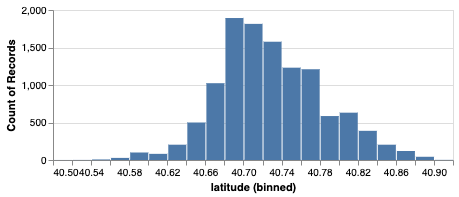

In [13]:
#3.3.1 Numerical feature distributions - latitude - normally distributed
latitude_hist = alt.Chart(train_df).mark_bar().encode(
     x = alt.X('latitude', type='quantitative', bin=alt.Bin(maxbins=40)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
latitude_hist

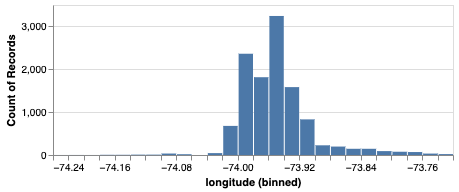

In [14]:
#3.3.2 Numerical feature distributions - longitude - quite normally distributed
longitude_hist = alt.Chart(train_df).mark_bar().encode(
     x = alt.X('longitude', type='quantitative', bin=alt.Bin(maxbins=40)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
longitude_hist

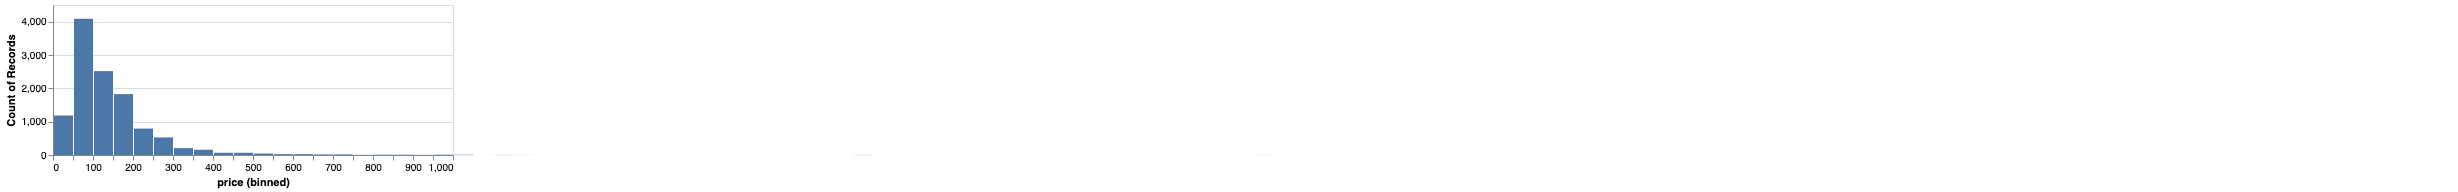

In [15]:
#3.3.3 Numerical feature distributions - price - right-skew distributed
price_hist = alt.Chart(train_df).mark_bar().encode(
     x = alt.X('price', type='quantitative', bin=alt.Bin(maxbins=200), scale=alt.Scale(domain=(0,1000))),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
price_hist

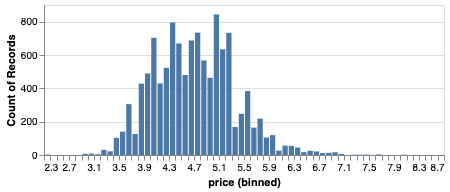

In [16]:
#3.3.4 Numerical feature distributions - log(price) - better normally distributed
# Since price is right-skew, we better transform it with long transformation
log_train_df = train_df.copy()
log_train_df['price'] = np.log(train_df['price'])
log_price_hist = alt.Chart(log_train_df).mark_bar().encode(
     x = alt.X('price', type='quantitative', bin=alt.Bin(maxbins=100)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
log_price_hist

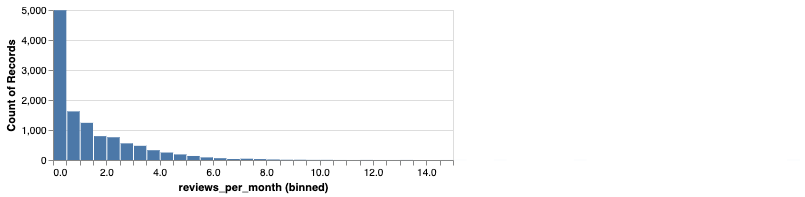

In [17]:
#3.3.5 Numerical feature distributions - reviews_per_month - right-skew distributed
reviews_per_month_hist = alt.Chart(train_df).mark_bar().encode(
     x = alt.X('reviews_per_month', type='quantitative', bin=alt.Bin(maxbins=100), scale=alt.Scale(domain=(0,15))),
     y = alt.Y('count()'),
).properties(
    width=400,
    height=150
)
# Show the plot
reviews_per_month_hist

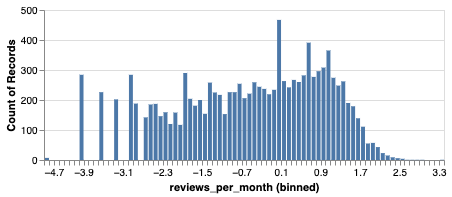

In [18]:
#3.3.6 Numerical feature distributions - log(reviews_per_month) - better normally distributed
# Since reviews_per_month is right-skew, we better transform it with long transformation
log_train_df = train_df.copy()
log_train_df['reviews_per_month'] = np.log(train_df['reviews_per_month'])
log_price_hist = alt.Chart(log_train_df).mark_bar().encode(
     x = alt.X('reviews_per_month', type='quantitative', bin=alt.Bin(maxbins=100)),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
log_price_hist

In [19]:
#3.3.7 Categorical feature distributions - host_id - value_counts()
# We moght keep it all since they are all unique value
train_df['host_id'].value_counts()

219517861    67
61391963     23
137358866    19
16098958     17
190921808    15
             ..
11968765      1
39134890      1
19868844      1
29349060      1
79369918      1
Name: host_id, Length: 10319, dtype: int64

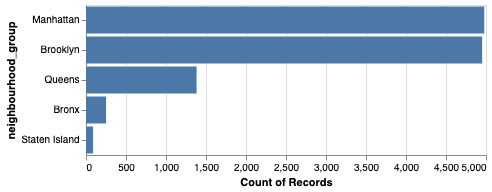

In [20]:
#3.3.8 Categorical feature distributions - neighbourhood_group
neighbourhood_group_hist = alt.Chart(train_df).mark_bar().encode(
    x = 'count()',
    y = alt.Y('neighbourhood_group', type='nominal', sort='-x')
     ,
).properties(
    width=400,
    height=150
)
# Show the plot
neighbourhood_group_hist

In [21]:
#3.3.9 Categorical feature distributions - neighbourhood_group - value_counts()
# We might keep it all
train_df['neighbourhood_group'].value_counts()

Manhattan        4978
Brooklyn         4952
Queens           1382
Bronx             251
Staten Island      88
Name: neighbourhood_group, dtype: int64

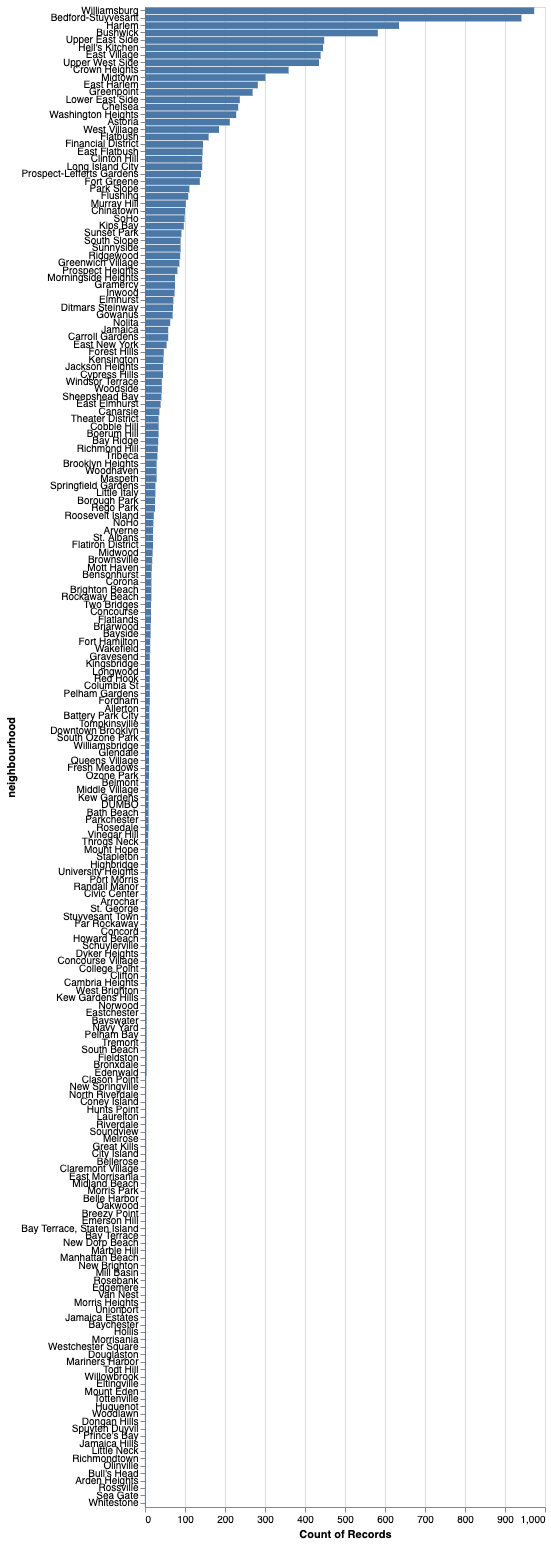

In [22]:
#3.3.10 Categorical feature distributions - neighbourhood
neighbourhood_hist = alt.Chart(train_df).mark_bar().encode(
    x = alt.X('count()'),
    y = alt.Y('neighbourhood', type='nominal', sort='-x')
).properties(
    width=400,
    height=1500
)
# Show the plot
neighbourhood_hist

In [23]:
#3.3.11 Categorical feature distributions - neighbourhood - value_counts()
# We might drop value_counts that less than 10 occurances
train_df['neighbourhood'].value_counts()

Williamsburg          973
Bedford-Stuyvesant    941
Harlem                635
Bushwick              582
Upper East Side       448
                     ... 
Tottenville             1
Huguenot                1
Dongan Hills            1
Woodlawn                1
Whitestone              1
Name: neighbourhood, Length: 202, dtype: int64

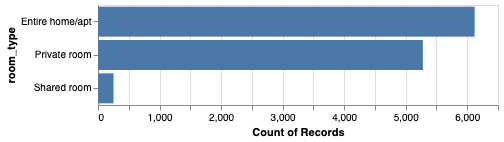

In [24]:
#3.3.12 Categorical feature distributions - room_type
room_type_hist = alt.Chart(train_df).mark_bar().encode(
    x = alt.X('count()'),
    y = alt.Y('room_type', type='nominal', sort='-x')
).properties(
    width=400,
    height=100
)
# Show the plot
room_type_hist

In [25]:
#3.3.13 Categorical feature distributions - room_type - value_counts()
# We might keep it all
train_df['room_type'].value_counts()

Entire home/apt    6120
Private room       5279
Shared room         252
Name: room_type, dtype: int64

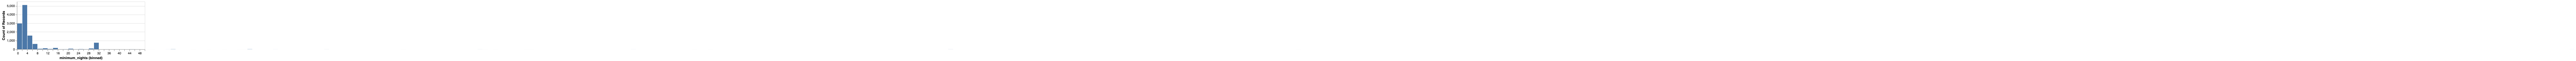

In [26]:
#3.3.14 Categorical feature distributions - minimum_nights - right-skew distributed
minimum_nights_hist = alt.Chart(train_df).mark_bar().encode(
     x = alt.X('minimum_nights', type='quantitative', bin=alt.Bin(maxbins=500), scale=alt.Scale(domain=(0,50))),
     y = 'count()',
).properties(
    width=400,
    height=150
)
# Show the plot
minimum_nights_hist

In [27]:
#3.3.15 Categorical feature distributions - minimum_nights - value_counts()
# We might drop value_counts that less than 10 occurances
train_df['minimum_nights'].value_counts()

2      3065
1      2975
3      2041
4       830
5       745
       ... 
198       1
47        1
88        1
68        1
183       1
Name: minimum_nights, Length: 61, dtype: int64

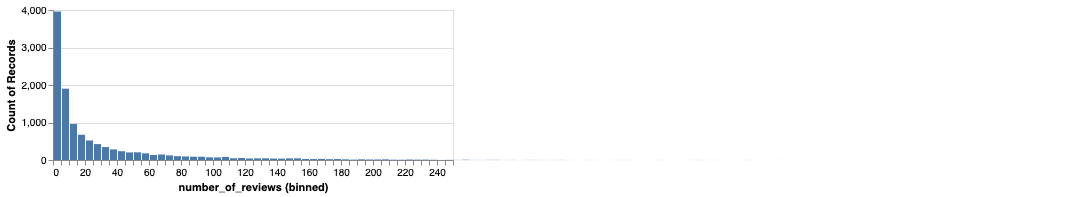

In [28]:
#3.3.16 Categorical feature distributions - number_of_reviews - right-skew distributed (OHE)
number_of_reviews_hist = alt.Chart(train_df).mark_bar().encode(
     x = alt.X('number_of_reviews', type='quantitative', bin=alt.Bin(maxbins=150), scale=alt.Scale(domain=(0,250))),
     y = alt.Y('count()'),
).properties(
    width=400,
    height=150
)
# Show the plot
number_of_reviews_hist

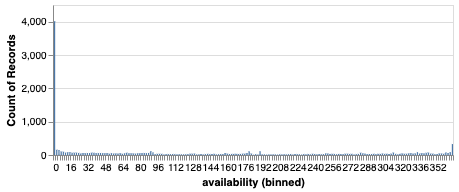

In [29]:
#3.3.17 Categorical feature distributions - availability - uniformly distributed
availability_hist = alt.Chart(train_df).mark_bar().encode(
     x = alt.X('availability', type='quantitative', bin=alt.Bin(maxbins=200)),
     y = alt.Y('count()'),
).properties(
    width=400,
    height=150
)
# Show the plot
availability_hist

In [30]:
#3.3.18 Categorical feature distributions - availability - value_counts()
# We might drop value_counts that less than 10 occurances
train_df['availability'].value_counts()

0      3872
365     230
1       138
364      96
3        86
       ... 
194       6
202       5
196       5
181       3
183       3
Name: availability, Length: 366, dtype: int64

(-0.5, 399.5, 199.5, -0.5)

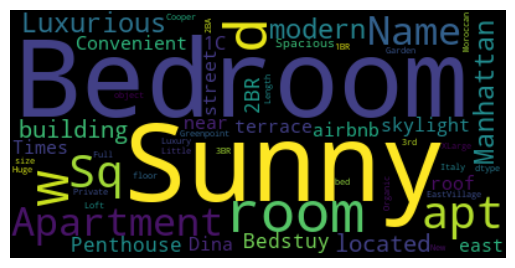

In [31]:
#3.3.19 Text feature wordcloud - name
wordcloud_name = WordCloud().generate(str(train_df['name']))
plt.imshow(wordcloud_name, interpolation='bilinear')
plt.axis("off")

In [32]:
#3.4 Correlation matrix : Pearson
train_df.corr('pearson').style.background_gradient().format(precision=2)

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability
host_id,1.00,0.01,0.13,0.01,-0.04,-0.15,0.30,0.16,0.14
latitude,0.01,1.00,0.09,0.04,0.03,-0.02,-0.02,0.00,-0.04
longitude,0.13,0.09,1.00,-0.20,-0.04,0.04,0.13,-0.09,0.11
price,0.01,0.04,-0.20,1.00,0.02,-0.04,-0.03,0.07,0.10
minimum_nights,-0.04,0.03,-0.04,0.02,1.00,-0.06,-0.11,0.06,0.10
number_of_reviews,-0.15,-0.02,0.04,-0.04,-0.06,1.00,0.55,-0.06,0.20
reviews_per_month,0.30,-0.02,0.13,-0.03,-0.11,0.55,1.00,-0.00,0.18
calculated_host_listings_count,0.16,0.00,-0.09,0.07,0.06,-0.06,-0.00,1.00,0.18
availability,0.14,-0.04,0.11,0.10,0.10,0.20,0.18,0.18,1.00


In [33]:
#3.5 Correlation matrix : Spearman
train_df.corr('spearman').style.background_gradient().format(precision=2)

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability
host_id,1.00,0.04,0.12,-0.09,-0.18,-0.11,0.26,0.12,0.11
latitude,0.04,1.00,0.04,0.13,0.03,-0.04,-0.03,-0.02,-0.04
longitude,0.12,0.04,1.00,-0.42,-0.10,0.06,0.10,0.11,0.10
price,-0.09,0.13,-0.42,1.00,0.11,-0.01,-0.01,-0.17,0.06
minimum_nights,-0.18,0.03,-0.10,0.11,1.00,-0.16,-0.28,-0.01,0.03
number_of_reviews,-0.11,-0.04,0.06,-0.01,-0.16,1.00,0.71,0.09,0.31
reviews_per_month,0.26,-0.03,0.10,-0.01,-0.28,0.71,1.00,0.15,0.39
calculated_host_listings_count,0.12,-0.02,0.11,-0.17,-0.01,0.09,0.15,1.00,0.37
availability,0.11,-0.04,0.10,0.06,0.03,0.31,0.39,0.37,1.00


# 4. Feature engineering

We will try to create more features with `nltk` package to have `number_of_words`, `sentiment`, and `number_of_chars` as new features.

In [34]:
#4.1 Feature engineering with nltk on text feature
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")
nltk.download("punkt")
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/boy_mbp14p/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/boy_mbp14p/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
def get_relative_length(text, TWITTER_ALLOWED_CHARS=280.0):
    """
    Returns the relative length of text.

    Parameters:
    ------
    text: (str)
    the input text

    Keyword arguments:
    ------
    TWITTER_ALLOWED_CHARS: (float)
    the denominator for finding relative length

    Returns:
    -------
    relative length of text: (float)

    """
    return len(text) / TWITTER_ALLOWED_CHARS


def get_length_in_words(text):
    """
    Returns the length of the text in words.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    length of tokenized text: (int)

    """
    return len(nltk.word_tokenize(text))


def get_sentiment(text):
    """
    Returns the compound score representing the sentiment: -1 (most extreme negative) and +1 (most extreme positive)
    The compound score is a normalized score calculated by summing the valence scores of each word in the lexicon.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    sentiment of the text: (str)
    """
    scores = sid.polarity_scores(text)
    return scores["compound"]

In [36]:
#4.2 Add new text features
train_df = train_df.assign(n_words=train_df["name"].apply(get_length_in_words))
train_df = train_df.assign(vader_sentiment=train_df["name"].apply(get_sentiment))
train_df = train_df.assign(rel_char_len=train_df["name"].apply(get_relative_length))

test_df = test_df.assign(n_words=test_df["name"].apply(get_length_in_words))
test_df = test_df.assign(vader_sentiment=test_df["name"].apply(get_sentiment))
test_df = test_df.assign(rel_char_len=test_df["name"].apply(get_relative_length))

In [37]:
#4.3 Inspect data
train_df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability,n_words,vader_sentiment,rel_char_len
21772,Luxurious Manhattan 1 Bedroom,3191545,Manhattan,Hell's Kitchen,40.76589,-73.98434,Entire home/apt,199,30,6,0.23,23,365,4,0.0000,0.103571
17591,Sunny room in modern building located in Bedstuy,252059,Brooklyn,Bedford-Stuyvesant,40.69181,-73.94312,Private room,60,5,3,0.08,1,0,8,0.4215,0.171429
15594,"Penthouse 2BR w skylight,terrace, and a roof d...",68094795,Manhattan,Upper East Side,40.76532,-73.96150,Entire home/apt,399,4,55,1.47,2,237,12,0.0000,0.178571
41598,Convenient 2 bedroom apt near Times Sq. 1C,190921808,Manhattan,Hell's Kitchen,40.75393,-73.99667,Entire home/apt,500,3,2,0.81,47,352,9,0.0000,0.150000
29321,Dina airbnb 61 street east D,164886138,Manhattan,Upper East Side,40.76015,-73.96227,Entire home/apt,140,2,4,0.53,11,354,6,0.0000,0.100000


# 5. Pipeline

In [38]:
#5.1 Separate X_train, y_train, X_test, y_test
X_train = train_df.drop(columns=['reviews_per_month'])
X_test = test_df.drop(columns=['reviews_per_month'])
y_train = train_df['reviews_per_month']
y_test = test_df['reviews_per_month']

X_train.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability,n_words,vader_sentiment,rel_char_len
21772,Luxurious Manhattan 1 Bedroom,3191545,Manhattan,Hell's Kitchen,40.76589,-73.98434,Entire home/apt,199,30,6,23,365,4,0.0000,0.103571
17591,Sunny room in modern building located in Bedstuy,252059,Brooklyn,Bedford-Stuyvesant,40.69181,-73.94312,Private room,60,5,3,1,0,8,0.4215,0.171429
15594,"Penthouse 2BR w skylight,terrace, and a roof d...",68094795,Manhattan,Upper East Side,40.76532,-73.96150,Entire home/apt,399,4,55,2,237,12,0.0000,0.178571
41598,Convenient 2 bedroom apt near Times Sq. 1C,190921808,Manhattan,Hell's Kitchen,40.75393,-73.99667,Entire home/apt,500,3,2,47,352,9,0.0000,0.150000
29321,Dina airbnb 61 street east D,164886138,Manhattan,Upper East Side,40.76015,-73.96227,Entire home/apt,140,2,4,11,354,6,0.0000,0.100000


In [39]:
#5.3.1 setup feature types
numerical_features = ['latitude', 'longitude', 'calculated_host_listings_count',
                      'n_words', 'vader_sentiment', 'rel_char_len']
log_features = ['price']
categorical_features = ['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 
                        'minimum_nights', 'number_of_reviews', 'availability']
text_features = ['name']
drop_features = []

#5.3.2 setup log transformation
def log_transform(x):
    return np.log1p(x)
log_transformer = make_pipeline(FunctionTransformer(log_transform), StandardScaler())

# 5.3.3 define pre-processor
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (log_transformer, log_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features), 
    (CountVectorizer(stop_words='english'), text_features[0]), 
    ("drop", drop_features)
)
preprocessor

#5.3.4 setup target transformer
# ttr = TransformedTargetRegressor(
#     Ridge(alpha=best_alpha), func=np.log1p, inverse_func=np.expm1
# ) # transformer for log transforming the target
# ttr_pipe = make_pipeline(preprocessor, ttr)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['latitude', 'longitude',
                                  'calculated_host_listings_count', 'n_words',
                                  'vader_sentiment', 'rel_char_len']),
                                ('pipeline',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function log_transform at 0x13b3209d0>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['price']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['host_id', 'neighbourhood_group',
                                  'neighbourhood', 'room_type',
                                  'minimum_nights', 'number_of_reviews',
                                  'availability']),
                                ('countvectorizer',
                                 CountVectorizer(stop_words='english'),
                                 'name'),
                                ('drop', 'drop', [])])

# 6. Baseline model

In [40]:
# Initial model result
cross_val_results = {}

In [41]:
# Baseline model with DummyRegressor
dc = make_pipeline(preprocessor, DummyRegressor())

# Cross-validation
cv_df = pd.DataFrame(
    cross_validate(
        dc, X_train, y_train, 
        cv = 5,
        return_train_score = True, 
        scoring = 'neg_mean_absolute_error'
    ))
cv_df

,fit_time,score_time,test_score,train_score
0,0.069973,0.014316,-1.214974,-1.224754
1,0.045036,0.011968,-1.200471,-1.230439
2,0.045628,0.012347,-1.236106,-1.215131
3,0.049308,0.012863,-1.227324,-1.219961
4,0.045520,0.012437,-1.231939,-1.220154


In [42]:
# Store CV score
cross_val_results['dummy'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['dummy']

,mean,std
fit_time,0.051,0.011
score_time,0.013,0.001
test_score,-1.222,0.014
train_score,-1.222,0.006


# 7. Linear models

In this section, I tried 2 types of linear models such Linear regression and Ridge.

For Ridge, I first tried with RidgeCV(), but it took very long time to run and finally my laptop was hank, so I decided to use Ridge() with RandomizedCV search to tune alpha parameter instead.

The cv score of DummyRegressor is -1.222, which the cv score of LinearRegression() is -1.101, and the cv score of Ridge() is -0.08619.
We can see that Ridge() with optimized regularization alpha parameter(alpha = 100) got the best result among Dummyregressor() and LinearRegression().

Please be noted that the score is negative mean absolute error.

In [43]:
#7.1 Linear regression model
linreg = make_pipeline(preprocessor, LinearRegression())

# 2. Cross-validation
cv_df = pd.DataFrame(
    cross_validate(
        linreg, X_train, y_train, 
        cv = 5,
        n_jobs = -1,
        return_train_score = True, 
        scoring = 'neg_mean_absolute_error'
    ))
cv_df

,fit_time,score_time,test_score,train_score
0,0.701447,0.013088,-1.085925,-0.001199
1,0.706004,0.013017,-1.128854,-0.001315
2,0.752256,0.014569,-1.138095,-0.001239
3,0.781279,0.013608,-1.071656,-0.001093
4,0.665607,0.013849,-1.079404,-0.001135


In [44]:
# Store CV score
cross_val_results['linreg'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['linreg']

,mean,std
fit_time,0.721,0.046
score_time,0.014,0.001
test_score,-1.101,0.030
train_score,-0.001,0.000


In [45]:
linreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'calculated_host_listings_count',
                                                   'n_words', 'vader_sentiment',
                                                   'rel_char_len']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function log_transform at 0x13b3209d0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['host_id',
                                                   'neighbourhood_group',
                                                   'neighbourhood', 'room_type',
                                                   'minimum_nights',
                                                   'number_of_reviews',
                                                   'availability']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'name'),
                                                 ('drop', 'drop', [])])),
                ('linearregression', LinearRegression())])

In [46]:
# #7.2 RidgeCV
# ridge = make_pipeline(preprocessor, RidgeCV())

# # Cross-validation
# cv_df = pd.DataFrame(
#     cross_validate(
#         ridge, X_train, y_train, 
#         cv = 5,
#         n_jobs = -1,
#         return_train_score = True, 
#         scoring = 'neg_mean_absolute_error'
#     ))
# cv_df

In [47]:
# CV Result - RidgeCV
# 	fit_time	score_time	test_score	train_score
# 0	168.101135	0.022934	-0.828360	-0.656584
# 1	167.307828	0.028862	-0.808181	-0.660795
# 2	167.078385	0.022136	-0.833462	-0.652634
# 3	166.910780	0.028145	-0.815436	-0.655816
# 4	167.708605	0.024845	-0.828871	-0.658148

In [48]:
# # 3. Find alpha
# ridge.fit(X_train, y_train)
# rp_ridge = ridge.named_steps["ridgecv"].alpha_
# rp_ridge
# rp_ridge = 1.0

In [49]:
#7.3 Ridge with RandomizedSearchCV
ridge = make_pipeline(preprocessor, Ridge())

param_grid = {
    "ridge__alpha": 10.0 ** np.arange(-10, 10, 1)
}
random_search_ridge = RandomizedSearchCV(
    ridge, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=5, 
    return_train_score=True, 
    scoring = 'neg_mean_absolute_error',
    random_state=123
)
random_search_ridge.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['latitude',
                                                                                'longitude',
                                                                                'calculated_host_listings_count',
                                                                                'n_words',
                                                                                'vader_sentiment',
                                                                                'rel_char_len']),
                                                                              ('pipeline',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(func=<function log_transform at 0x13b3209d...
                                                                               CountVectorizer(stop_words='english'),
                                                                               'name'),
                                                                              ('drop',
                                                                               'drop',
                                                                               [])])),
                                             ('ridge', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09])},
                   random_state=123, return_train_score=True,
                   scoring='neg_mean_absolute_error')

In [50]:
#7.4 CV result - Ridge with RandomizedSearchCV
result_ridge = pd.DataFrame(random_search_ridge.cv_results_)[
    [
        "mean_fit_time",
        "mean_score_time",
        "mean_test_score",
        "mean_train_score",
        'std_fit_time',
        'std_score_time',
        'std_test_score',
        'std_train_score',
        "param_ridge__alpha",
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().iloc[[0],:]

# Store CV score
data = {'mean': list(result_ridge.iloc[0,0:4]),
        'std': list(result_ridge.iloc[0,4:8])}
cross_val_results['ridge'] = pd.DataFrame(data)
cross_val_results['ridge'].index=["fit_time", "score_time",'test_score','train_score']
cross_val_results['ridge']

,mean,std
fit_time,0.093014,0.011385
score_time,0.018153,0.005424
test_score,-0.861934,0.011784
train_score,-0.821792,0.003581


In [51]:
#7.5 Find best param
rp_ridge = random_search_ridge.best_params_
rp_ridge

{'ridge__alpha': 100.0}